Author: Sayantan Mitra <br>
Chief Data Scientist, Compton & Wendler<br>
Ph.D. candidate, Baylor College of Medicine

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

# VisualiZation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Goal 1: Predict cost of solar panels of unseen data based on ML pipeline saved in notebook 3

In [2]:
new_data = pd.read_csv('new_data_cost.csv', usecols=['state', 'cost', 'zipcode', 'installer', 'city', 
                                                'tech_1', 'county', 'annual_PV_prod', 'year'])
new_data.head()

,state,zipcode,installer,cost,city,tech_1,county,annual_PV_prod,year
0,CA,90046,California Green Designs,76530.0,Los Angeles,Poly,Los Angeles,23142.420310,2012
1,CA,95451,RGS/Real Goods,67211.0,Kelseyville,Mono,Lake,14890.919010,2012
2,MA,1606,SolarCity,17160.0,Worcester,NaN,Worcester,4079.730586,2015
3,AZ,85379,SolarCity,23625.0,SURPRISE,Poly,Maricopa,8973.857300,2013
4,CA,92692,Verengo,23650.0,MISSION VIEJO,Poly,Orange,8268.739153,2015


In [3]:
solar_train = pd.read_csv('solar_train_cost.csv', usecols=['state', 'cost', 'zipcode', 'installer', 'city', 
                                                'tech_1', 'county', 'annual_PV_prod', 'year'])
# Extract 1st number of zipcode
solar_train['zipcode_1'] = solar_train['zipcode'].astype('str').str[:1]
new_data['zipcode_1'] = new_data['zipcode'].astype('str').str[:1]
# year as a categorical column to take care of cardinality
solar_train['year'] = solar_train['year'].astype('str')
new_data['year'] = new_data['year'].astype('str')

# Check cardinality
def group_levels_in_categoricals(df, threshold=0.01, min_freq=0, max_freq=np.Inf):
    df0 = df.describe(include=['O']).T
    # reduced list is name of categorical columns
    reduced_list = df0[(df0.unique < max_freq) & (df0.unique > min_freq)].reset_index()['index'].tolist()
    
    #patterns will contain list of all categories of all categorical column whose occurance is more than threshold
    patterns = []
    other = []
    for col in reduced_list:
        df_normalized = df[col].value_counts(normalize=True).reset_index()
        df_normalized.columns = ['col_name', 'normalized_value']
        filt = df_normalized['normalized_value'] > threshold
        # norm_list contains all the categories in a categorical column whose occurance is more than threshold    
        norm_list = df_normalized[filt]['col_name'].tolist()
        pattern = norm_list
        patterns.append(norm_list)
        # selecting categories that are present less than threshold
        others_list = df_normalized[~filt]['col_name'].tolist()
        other.append(others_list)
        
        if pattern != []: 
            df[col] = df[col].replace({x:'Other' for x in others_list})
        else:
            df.drop(col, inplace=True, axis=1)
    return (df, patterns, reduced_list, other)
df, patterns, reduced_list, other = group_levels_in_categoricals(solar_train)

# We have to keep this consistent with test data as well
def group_levels_in_categoricals_test(reduced_list, other, patterns, df_test):   
    for idx, col in enumerate(reduced_list):       
        if other[idx] != []:
            filt = df_test[col].isin(patterns[idx])
            df_test[col][~filt]='Others'
        else:
            df_test.drop(col, inplace=True, axis=1)       
    return df_test
new_data = group_levels_in_categoricals_test(reduced_list, other, patterns, new_data)

**Data Preparation**

In [4]:
# Feature engineering like train set in Notebook 2
solar_train['cost_L'] = np.log1p(solar_train['cost'])
new_data['cost_L'] = np.log1p(new_data['cost'])
solar_train['annual_PV_prod_L'] = np.log1p(solar_train['annual_PV_prod'])
new_data['annual_PV_prod_L'] = np.log1p(new_data['annual_PV_prod'])

# Dependent variable
new_data_real_cost = new_data['cost']
y = new_data[['cost_L']]
y1 = new_data['cost_L']
# Independent variables
solar_train = solar_train.drop(columns=['cost', 'cost_L', 'zipcode', 'annual_PV_prod'])                         
new_data = new_data.drop(columns=['cost', 'cost_L', 'zipcode', 'annual_PV_prod']) 

### Testing the ridge model (ML pipeline) on unseen data

In [5]:
from sklearn.externals import joblib
rg1 =joblib.load('cost_prediction_model.joblib')
print(f'Saved ridge_model_r2 with new_data: {rg1.score(new_data, y1).round(4)}')

Saved ridge_model_r2 with new_data: 0.7939


**Plotting predicted and actual cost of the solar panels**

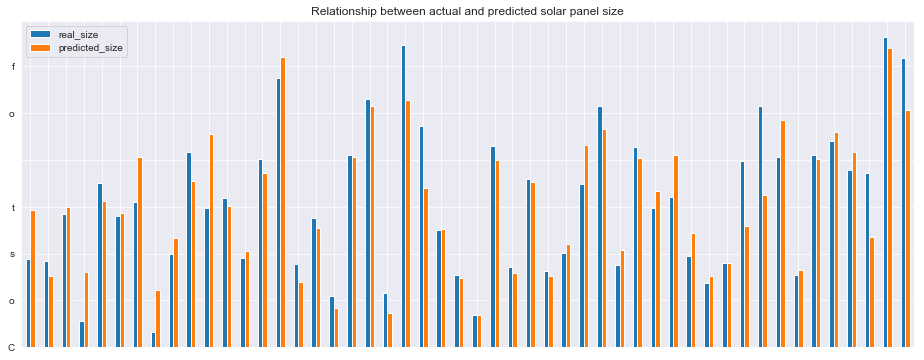

In [6]:
# Relationship between actual solar panel and predicted solar panel size (transformed)
fig, axes = plt.subplots(1,1, figsize = (16,6))
y_pred_actual = np.exp(rg1.predict(new_data))
size_pred = pd.DataFrame({'real_size':new_data_real_cost, 'predicted_size':y_pred_actual})
size_pred.sample(n=50).plot(kind='bar', ax=axes)
axes.set_title('Relationship between actual and predicted solar panel size')
axes.set_xticklabels('')
axes.set_yticklabels('Cost of solar panels');

■ Prediction for the cost of solar panels is in line with notebook 3.

### Goal 2: Let's see whether uncle Bob can afford his new solar panel !

→ Details of uncle_bob specification in notebook 4

In [10]:
uncle_bob  =pd.DataFrame({'state': 'CA', 'zipcode':93444, 'installer':'SolarCity', 
                          'city':'Nipomo', 'tech_1': 'Poly', 'county':'San Luis Obispo', 
                          'annual_PV_prod': 6262.51, 'year':'2014'}, index=[0])
# Extract 1st number of zipciode
uncle_bob['zipcode_1'] = uncle_bob['zipcode'].astype('str').str[:1]
uncle_bob

,state,zipcode,installer,city,tech_1,county,annual_PV_prod,year,zipcode_1
0,CA,93444,SolarCity,Nipomo,Poly,San Luis Obispo,6262.51,2014,9


**Data preparation**

In [11]:
new_data = pd.read_csv('new_data_cost.csv', usecols=['state', 'cost', 'zipcode', 'installer', 'city', 
                                                'tech_1', 'county', 'annual_PV_prod', 'year'])
solar_train = pd.read_csv('solar_train_cost.csv', usecols=['state', 'cost', 'zipcode', 'installer', 'city', 
                                                'tech_1', 'county', 'annual_PV_prod', 'year'])
new_data['zipcode_1'] = new_data['zipcode'].astype('str').str[:1]
solar_train['zipcode_1'] = solar_train['zipcode'].astype('str').str[:1]
uncle_bob_test = new_data.append(uncle_bob, ignore_index=True)
# year as a categorical column to take care of cardinality
solar_train['year'] = solar_train['year'].astype('str')
uncle_bob_test['year'] = uncle_bob_test['year'].astype('str')
# Align columns
uncle_bob_test = uncle_bob_test[solar_train.columns]

# cardinality
df, patterns, reduced_list, other = group_levels_in_categoricals(solar_train)
uncle_bob_test = group_levels_in_categoricals_test(reduced_list, other, patterns, uncle_bob_test)

# Feature engineering like train set in Notebook 2
#solar_train['cost_L'] = np.log1p(solar_train['cost'])
uncle_bob_test['cost_L'] = np.log1p(uncle_bob_test['cost'])
#solar_train['annual_PV_prod_L'] = np.log1p(solar_train['annual_PV_prod'])
uncle_bob_test['annual_PV_prod_L'] = np.log1p(uncle_bob_test['annual_PV_prod'])

#solar_train = solar_train.drop(columns=['cost', 'cost_L', 'zipcode', 'annual_PV_prod'])                         
uncle_bob_test = uncle_bob_test.drop(columns=['cost', 'cost_L', 'zipcode', 'annual_PV_prod']) 

### Predicting cost of the solar panel uncle Bob need to install based on power consumption !

In [12]:
uncle_bob_pred = np.exp(rg1.predict(uncle_bob_test))
size_array = pd.DataFrame(uncle_bob_pred)
df = pd.concat([uncle_bob_test, size_array], axis=1)
df['annual_PV_prod']  = np.exp(df['annual_PV_prod_L'])
df.rename(columns={0: 'predicted_cost'}, inplace=True)
df.iloc[[-1],[-1,-2]]

,annual_PV_prod,predicted_cost
78053,6263.51,22254.175477


Uncle bob need to invest **~$20k** to install solar panel of 5.32kw (from notebook 4) to replace total annual traditional energy consumption of 6262.51kwh.

■ Next step is to add a DASH based app.